# `hw4`: Historical CO2 and temperature data

In [1]:
# Fill in this cell with your personal details:
# - Name: Mvomo Eto Wilfried 
# - Student ID: s226625
# - Email: Wilfried.MvomoEto@student.uliege.behttp://localhost:8888/notebooks/hh.ipynb#hw4:-Historical-CO2-and-temperature-data

Deadline: **Friday, December 22, 23:59**.

Instructions:
- Submit your completed notebook on your personal Github repository created when accepting the assignment.
- All cells must be executable and their outputs should not be erased before submission.
- This case study must be carried out alone. You are not allowed to discuss or collaborate with other students.
- In January, you will have to explain and defend your solution during a 30-minute oral exam.
- The take-home exam (including its defense in January) will account for 50% of the final grade.

Comments:
- Solve the case study below by following the Bayesian workflow as best as possible.
- Follow the data visualization principles to make your plots effective and readable.
- Make the best use of the Python scientific ecosystem.
- Feel free to add comments when necessary.

# Introduction

Analyses of ice cores from the Vostok station in East Antarctica have shown that the concentration of CO2 in the atmosphere and the temperature at the surface of the Earth are correlated (Petit et al, 1999). The goal of this case study is to analyze these two time series and quantify their relationship.

The data provided for this case study include 200 values of temperature measured at roughly equally spaced time intervals, with time between consecutive measurements being approximately 2000 years. For each value of temperature, the dataset also includes the  value of CO2 concentration corresponding to a date that is roughly 1000 years previous to the date of the temperature measurement. Temperatures are given in terms of its deviation from the average current temperature and CO2 concentrations are given in parts per million by volume (ppm).

![](drilling.jpg)


# Data exploration

<div class="alert alert-success">
    
**Q1**. Load the `icecore.csv` dataset into a data frame.
    
</div>

In [118]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import describe, mode
from sklearn.metrics import mean_squared_error
from scipy.stats import norm, gamma, multivariate_normal, uniform, beta

import emcee
import corner
from scipy.optimize import minimize
from scipy.linalg import eigh
from IPython.display import Image, display
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [119]:
data = pd.read_csv(r'./icecore.csv')

In [120]:
print(data.info())
data.iloc[:,1:].head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   year        200 non-null    float64
 2   co2         200 non-null    float64
 3   tmp         200 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 6.4 KB
None


,year,co2,tmp
0,-419095.0,277.6,0.94
1,-416872.0,286.9,1.36
2,-414692.0,285.5,1.07


<div class="alert alert-success">
    
**Q2**. Explore the dataset and report relevant insights.

</div>

The statistical formula : a = cov($CO_2$, $tmp$) / var($CO_2$), helps us to get the blue regression 
line in the scatter plot and whose the corresponding equation is : $ y = ax + b $ where $a = 0.08$ and $b = -23.16$. Noting that the mean point belongs to this regression line.

beta_1 = 0.08025417615215187 via statistic formula.
beta_0 = -23.115499174176946
Covariance: 64.1555533919598
Correlation Matrix:
           co2       tmp
co2  1.000000  0.828634
tmp  0.828634  1.000000


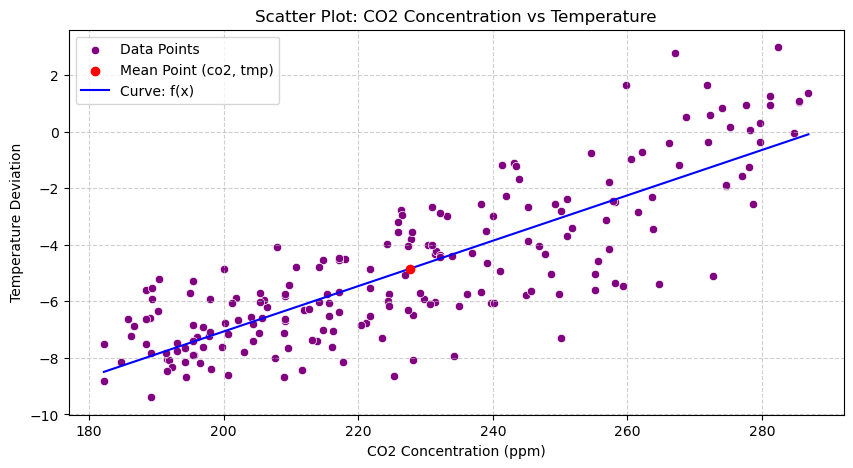

In [5]:
# Calculate correlation coefficient
covariance_matrix = np.cov(data['co2'], data['tmp'])
covariance_co2_tmp = covariance_matrix[0, 1]  # Covariance between 'co2' and 'tmp'
variance_co2 = np.var(data['co2'])  # Variance of 'co2'

correlation_coefficient = covariance_co2_tmp / variance_co2

# Print the correlation coefficient
print("beta_1 =", correlation_coefficient, "via statistic formula.")
print("beta_0 =", -correlation_coefficient * data['co2'].mean() + data['tmp'].mean())

# Print covariance
print("Covariance:", covariance_co2_tmp)

# Calculate the correlation matrix
correlation_matrix = data[['co2', 'tmp']].corr()
print("Correlation Matrix:\n", correlation_matrix)

# Plot the scatter plot
plt.figure(figsize=(10, 5))
sns.scatterplot(x='co2', y='tmp', data=data, color='purple', label='Data Points')

# Plot the point (data['co2'].mean(), data['tmp'].mean()) in red
plt.scatter(data['co2'].mean(), data['tmp'].mean(), color='red', label='Mean Point (co2, tmp)', zorder=5)

# Generate x values
x_values = np.linspace(data['co2'].min(), data['co2'].max(), 100)

# Calculate corresponding y values using the specified function
y_values = correlation_coefficient * x_values + (-correlation_coefficient * data['co2'].mean() + data['tmp'].mean())

# Plot the curve
plt.plot(x_values, y_values, color='blue', label='Curve: f(x)')

# Show the grid
plt.grid(True, linestyle='--', alpha=0.6)

# Show the legend
plt.legend()

# Add titles and labels
plt.title('Scatter Plot: CO2 Concentration vs Temperature')
plt.xlabel('CO2 Concentration (ppm)')
plt.ylabel('Temperature Deviation')

# Show the plot
plt.show()

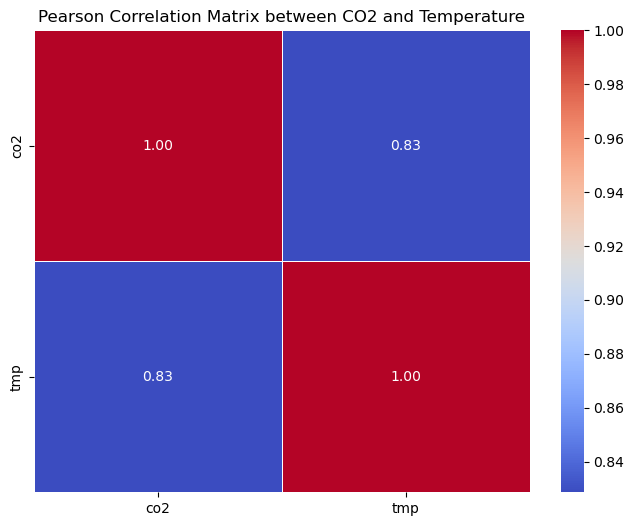

In [6]:
# Compute correlation matrix
correlation_matrix = data[['co2', 'tmp']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Pearson Correlation Matrix between CO2 and Temperature')
plt.show()

The both variables (temperature and $CO_2$) are strongly correlated. we can observe that through the Pearson correlation matrix above.

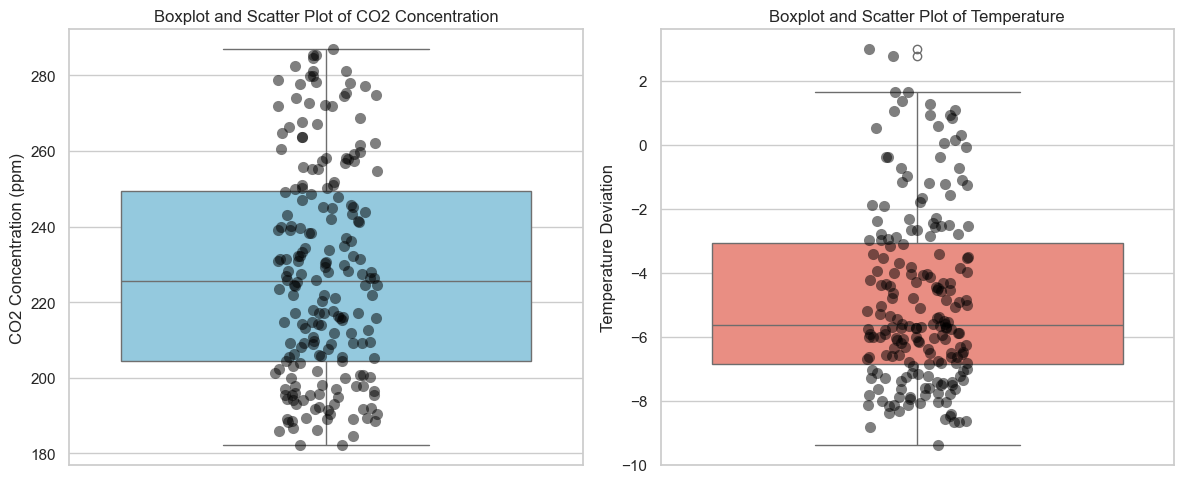

In [7]:
sns.set(style="whitegrid")

# Create a mix of boxplot and scatter plot for CO2 concentration and temperature
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Boxplot for CO2 concentration
sns.boxplot(y='co2', data=data, color='skyblue', ax=axes[0])
sns.stripplot(y='co2', data=data, color='black', size=8, jitter=True, alpha=0.5, ax=axes[0])
axes[0].set_title('Boxplot and Scatter Plot of CO2 Concentration')
axes[0].set_ylabel('CO2 Concentration (ppm)')

# Boxplot for temperature
sns.boxplot(y='tmp', data=data, color='salmon', ax=axes[1])
sns.stripplot(y='tmp', data=data, color='black', size=8, jitter=True, alpha=0.5, ax=axes[1])
axes[1].set_title('Boxplot and Scatter Plot of Temperature')
axes[1].set_ylabel('Temperature Deviation')

plt.tight_layout()
plt.show()

There are some outlying observations in the Temperature variables. Indeed their values are larger than the upper (extreme) bar of the Temperature's box plot. We must drop their corresponding rows in the data frame.

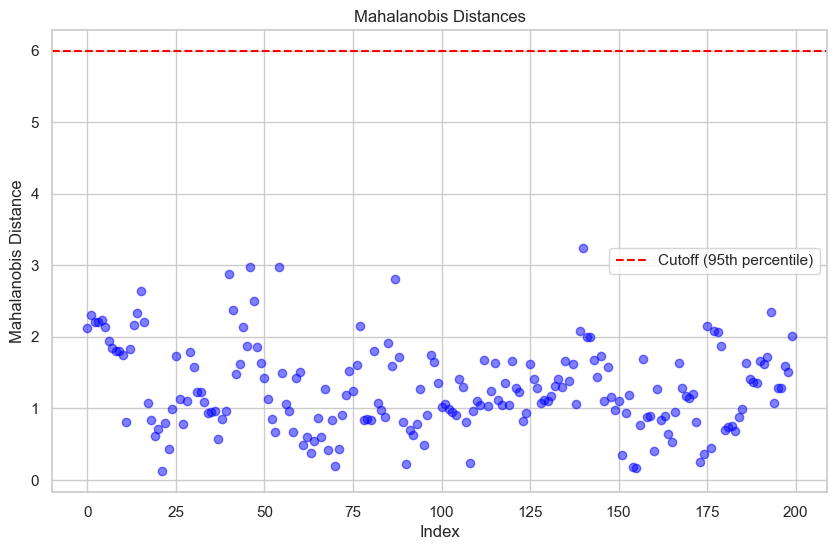

In [8]:
from scipy.spatial import distance
from scipy.stats import chi2

# Calculate the number of variables
num_variables = 2

# Calculate the quantile corresponding to the 95th percentile of the chi-square distribution
quantile = chi2.ppf(0.95, num_variables)

# Calculate the mean vector
mean_vector = data[['co2', 'tmp']].mean()

# Calculate the covariance matrix
cov_matrix = data[['co2', 'tmp']].cov()

# Compute the inverse of the covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Calculate Mahalanobis distance for each data point
mahalanobis_distances = []
for index, row in data.iterrows():
    data_point = row[['co2', 'tmp']]
    mahalanobis_distance = distance.mahalanobis(data_point, mean_vector, inv_cov_matrix)
    mahalanobis_distances.append(mahalanobis_distance)

# Add the Mahalanobis distances as a new column to your DataFrame
data['mahalanobis_distance'] = mahalanobis_distances

# Plot cleaned data
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['mahalanobis_distance'], marker='o', linestyle='', color='blue', alpha=0.5)
plt.axhline(y=quantile, color='red', linestyle='--', label='Cutoff (95th percentile)')
plt.title('Mahalanobis Distances')
plt.xlabel('Index')
plt.ylabel('Mahalanobis Distance')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Determine observations above cutoff
above_cutoff = data[data['mahalanobis_distance'] > quantile]
num_above_cutoff = len(above_cutoff)
print("Number of observations above cutoff:", num_above_cutoff)

# Delete observations above cutoff
data = data[data['mahalanobis_distance'] <= quantile]

Number of observations above cutoff: 0


No outlying obseravtion in the data set based on the Mahalanobis distance.

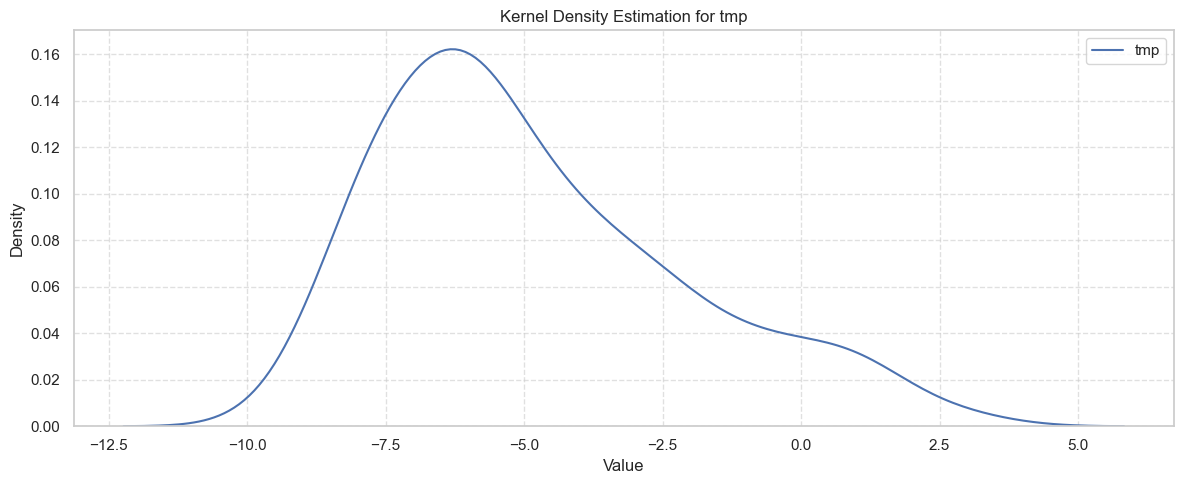

In [10]:
# Plotting a single kernel density plot
plt.figure(figsize=(12, 5))
sns.kdeplot(data['tmp'], label='tmp')

plt.title(f'Kernel Density Estimation for tmp')
plt.xlabel('Value')
plt.ylabel('Density')

# Show the grid
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend()
plt.tight_layout()
plt.show()

In [11]:
columns = ['tmp']
# Compute kurtosis and skewness for 'co2' and 'tmp'
kurtosis_values = data[columns].apply(kurtosis)
skewness_values = data[columns].apply(skew)

# Print the results
for column in columns:
    print(f"{column} Kurtosis: {kurtosis_values[column]:.2f}")
    print(f"{column} Skewness: {skewness_values[column]:.2f}")
    print("------------------------")

tmp Kurtosis: -0.09
tmp Skewness: 0.80
------------------------


The $CO_2$ variable mode is around on 205 while the one of Temperature variable is around -7.6. Under normal distribution, a skewness is 0 and a kurtosis is 3. However, the different kurtosis and skewness values of the $CO_2$ and Temperature features are obviously different to 3 and 0 respectively, meaning that their distributions are not Gaussian.

# Build: Probabilistic modelling

Our goal is to assess the correlation between CO2 concentration and temperature. In statistical terms, we will make this assessment through a linear regression model. Denoting by $\mathbf{x} = (x_1, \ldots, x_N)$ the CO2 concentration measurements and by $\mathbf{y} = (y_1, \ldots, y_N)$ the temperature measurements, we will consider two variations of the linear regression model:

- **Model 1**. The temperature is a linear function of CO2 concentration with additive uncorrelated Gaussian noise: $p(\mathbf{y} \mid \mathbf{x}, \theta) = \mathcal{N}(\mathbf{y} \mid \beta_0 + \beta_1 \mathbf{x}, \sigma^2 \mathbf{I})$.
- **Model 2**. The temperature is a linear function of CO2 concentration with additive correlated Gaussian noise: $p(\mathbf{y} \mid \mathbf{x}, \theta) = \mathcal{N}(\mathbf{y} \mid \beta_0 + \beta_1 \mathbf{x}, \sigma^2 \mathbf{C}_\rho)$, where $\mathbf{C}_\rho = [\rho^{|i - j|}]_{i,j=1}^N$ is a first-order autoregressive correlation matrix with parameter $\rho$. The $i$ and $j$ indexes denote the positions of the entries in the dataset (ordered by time).

Parameters $\beta_0$, $\beta_1$, $\sigma^2$ and $\rho$ are unknown and must be estimated from the data. They will come with their own prior distributions.

<div class="alert alert-success">
    
**Q3**. Draw the probabilistic graphical models associated with the two models above.
    
</div>

For the model 1: $\theta = (\beta_0, \beta_1, \sigma^2)$.

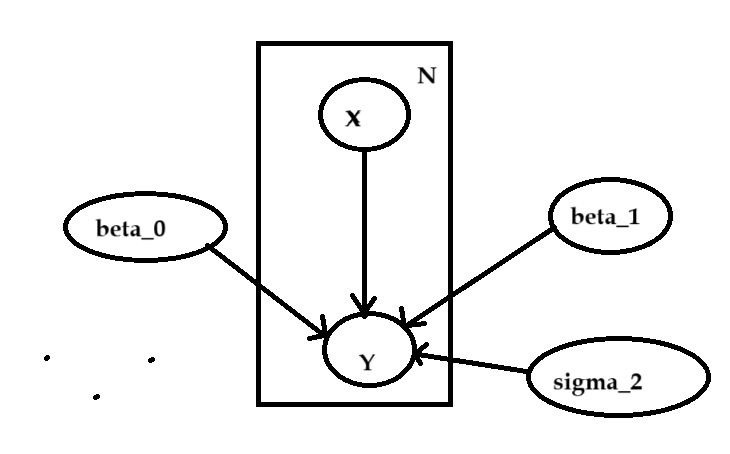

In [12]:
display(Image(filename=r'./model1.png'))

For the model 2:  $\theta = (\beta_0, \beta_1, \sigma^2,\rho^1, ...,\rho^{N-1})$.

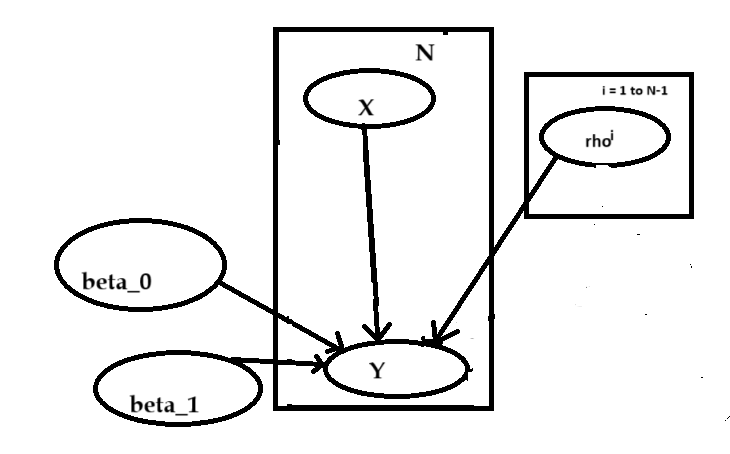

In [13]:
display(Image(filename=r'./model2.png'))

<div class="alert alert-success">
    
**Q4**. Implement the models defined above. For the time being, consider an uninformative prior for the model parameters.
    
</div>

In this step, we use uniform distrinution as an uniformative prior distribution for the model parameters.

In [14]:
# Implementing model 1: theta[0] = beta_0, theta[1] = beta_1, theta[2] = sigma_2
def simulate_mod1(x, theta):
    n = len(x)
    mu = theta[0] + theta[1] * x
    sigma_2 = theta[2]   # Covariance matrix is sigma^2 * identity matrix
    noise = multivariate_normal(mean=np.zeros(n), cov=sigma_2 * np.eye(n)).rvs()
    y = mu + noise

    return y

In [15]:
# 𝑃((x,𝑦)|𝛽0,𝛽1,𝜎2)
# Simulate samples from the uninformative prior distributions
def simulateMod1(x, num):
    # Simulate samples from the uniform distributions
    sigma_2_prior = uniform(loc=data['tmp'].var(), scale=1).rvs(num)
    beta_0_prior = uniform(loc=-5, scale=1e-1).rvs(num)
    beta_1_prior = beta(0.01, 1).rvs(num)

    # Simulate temperature samples
    tmp_samples = []
    realized_params = []

    for i in range(num):
        # Simulate joint distribution of all parameters
        theta_i = [beta_0_prior[i], beta_1_prior[i], sigma_2_prior[i]]

        # Simulate temperature samples using the provided simulation function
        tmp_sample_i = simulate_mod1(x, theta_i)

        tmp_samples.append(tmp_sample_i)
        realized_params.append({'beta_0': theta_i[0], 'beta_1': theta_i[1], 'sigma_2': theta_i[2]})

    return {'tmp_samples': np.array(tmp_samples), 'realized_params': realized_params}

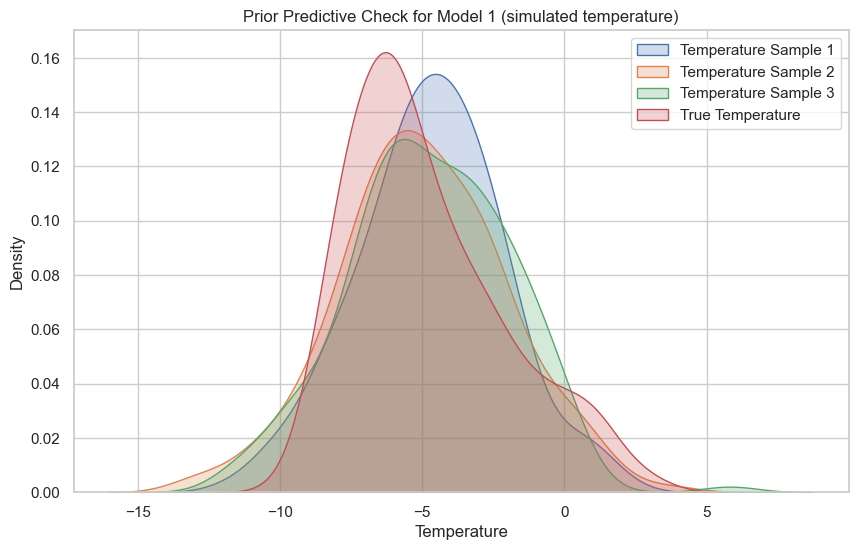

In [16]:
np.random.seed(1)
# Simulating
simulation_result2 = simulateMod1(data['co2'], num=3)

# Plot the realized temperature samples
plt.figure(figsize=(10, 6))
for i,tmp_sample_i in enumerate(simulation_result2['tmp_samples']):
    sns.kdeplot(tmp_sample_i, label=f'Temperature Sample {i + 1}', fill=True)
    
sns.kdeplot(data['tmp'], label='True Temperature', fill=True)
plt.title('Prior Predictive Check for Model 1 (simulated temperature)')
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.legend()
plt.show()

In [17]:
# Implementing model 2: theta[0] = beta_0, theta[1] = beta_1, theta[2] = sigma_2, theta[3] = rho
def simulate_mod2(x, theta):
    n = len(x)
    mu = theta[0] + theta[1] * x
    sigma_2 = theta[2]
    rho = theta[3]

    # Generate correlated Gaussian noise
    cov_matrix = np.array([[rho**abs(i - j) if i != j else 1 for i in range(n)] for j in range(n)])
    noise = multivariate_normal(mean=np.zeros(n), cov=sigma_2 * cov_matrix).rvs()

    # Simulated temperature
    y = mu + noise

    # Check and print a warning if rho is outside the range ]-1, 1[
    if not (-1 < rho < 1):
        print("Warning: rho value is outside the range ]-1, 1[.")
    
    return y

In [18]:
# 𝑃((x,𝑦)|𝛽0,𝛽1,𝜎2,rho)
def simulateMod2(x, num):
    # Simulate samples from the uniform distributions
    sigma_2_prior = uniform(loc=data['tmp'].var(), scale=1).rvs(num)
    beta_0_prior = uniform(loc=-5, scale=1e-1).rvs(num)
    beta_1_prior = beta(0.01, 1).rvs(num)
    rho_prior = uniform(loc=-1, scale=2).rvs(num)  

    # Simulate temperature samples
    y_samples = []

    for i in range(num):
        # Simulate joint distribution of all parameters
        theta_i = [beta_0_prior[i], beta_1_prior[i], sigma_2_prior[i], rho_prior[i]]

        # Simulate temperature samples using the provided simulation function
        y_sample_i = simulate_mod2(x, theta_i)

        y_samples.append(y_sample_i)
    return {'y_samples': np.array(y_samples)}

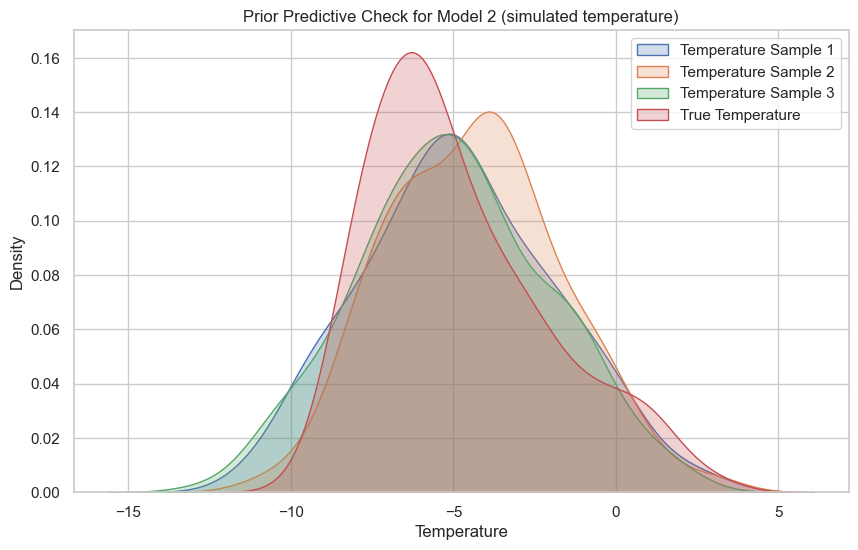

In [19]:
# np.random.seed(6)
# Simulate
simulation_result2 = simulateMod2(data['co2'], num=3)

# Plot the realized temperature samples
plt.figure(figsize=(10, 6))
for i,tmp_sample_i in enumerate(simulation_result2['y_samples']):
    sns.kdeplot(tmp_sample_i, label=f'Temperature Sample {i + 1}', fill=True)
    
sns.kdeplot(data['tmp'], label='True Temperature', fill=True)
plt.title('Prior Predictive Check for Model 2 (simulated temperature)')
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.legend()
plt.show()

<div class="alert alert-success">
    
**Q5**. Using a prior predictive check, evaluate and discuss if the prior predictive distribution is realistic. Propose a weakly informative prior that results in more realistic simulated data.
    
</div>

Prior choices:

The choice of $\sigma^2$ has been oriented towards the gamma distribution since it is positive.
Regarding $\beta_0$ and $\beta_1$ we chose the normal distribution as their values are set in $\mathbb{R}$. And finally, the parameter $\rho$  is oriented towards the  uniform law [-0.99,0.99] because $\rho$ represents the correlation value, and hence $\rho \in ]-1,1[$.

With the model 1 : 

Let's start by defining the full joint probability distribution: 

$P((x,y), \beta_0,\beta_1, \sigma^2) = P(\beta_0) \cdot P(\beta_1) \cdot P(\sigma^2) \cdot P(( x,y)|\beta_0,\beta_1, \sigma^2)$

$P((x,y), \beta_0,\beta_1, \sigma^2) = P(\beta_0) \cdot P(\beta_1) \cdot P(\sigma^2)\cdot {\prod_{i=1}^{N} P((x_i,y_i)|,\beta_0,\beta_1, \sigma^2 )}$

In [20]:
# Prior predictive check for model 1
#  𝑃(𝑦,𝛽0,𝛽1,𝜎2|𝑥)
def simulate_joint_mod1(x, num):
    # Simulate samples from the prior distributions
    sigma_2_prior = gamma(1, scale=data['tmp'].var()/3).rvs(num)
    beta_0_prior = norm(loc=-23, scale=1).rvs(num)
    beta_1_prior = norm(loc=0.08, scale=1e-3).rvs(num)

    # Simulate temperature samples
    tmp_samples = []
    realized_params = []

    for i in range(num):
        # Simulate joint distribution of all parameters
        theta_i = [beta_0_prior[i], beta_1_prior[i], sigma_2_prior[i]]

        # Simulate temperature samples using the provided simulation function
        tmp_sample_i = simulate_mod1(x, theta_i)

        tmp_samples.append(tmp_sample_i)
        realized_params.append({'beta_0': theta_i[0], 'beta_1': theta_i[1], 'sigma_2': theta_i[2]})

    return {'tmp_samples': np.array(tmp_samples), 'realized_params': realized_params}

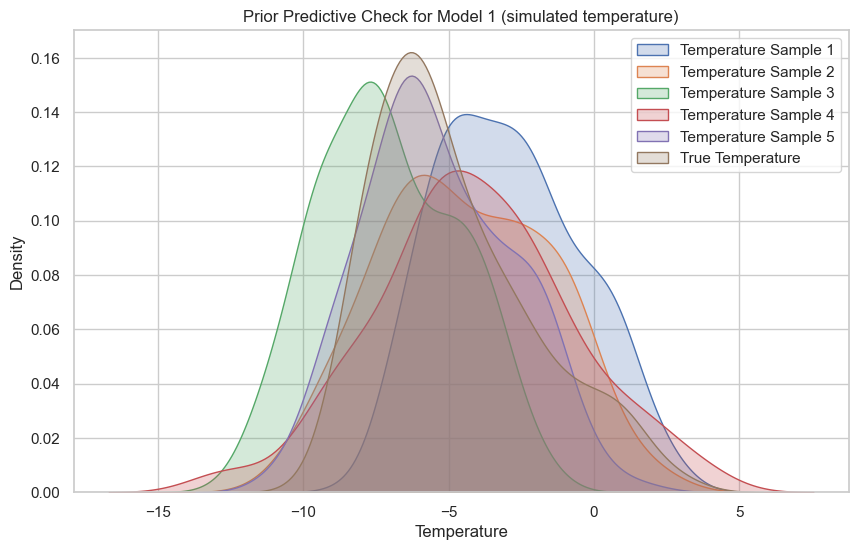

In [21]:
# Simulate
np.random.seed(5)
simulation_result = simulate_joint_mod1(data['co2'], num=5)

# Plot the realized temperature samples
plt.figure(figsize=(10, 6))
for i,tmp_sample_i in enumerate(simulation_result['tmp_samples']):
    sns.kdeplot(tmp_sample_i, label=f'Temperature Sample {i + 1}', fill=True)
    
sns.kdeplot(data['tmp'], label='True Temperature', fill=True)
plt.title('Prior Predictive Check for Model 1 (simulated temperature)')
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.legend()
plt.show()

In [22]:
# Determining relevant statistics of the simulated temperature and comparing them 
# to those of the true observed temperature
simulated_data_n1 = simulation_result['tmp_samples'][0]
simulated_data_n2 = simulation_result['tmp_samples'][1]
simulated_data_n3 = simulation_result['tmp_samples'][2]
true_data_tmp = data['tmp']

simulated_data_list = [simulated_data_n1, simulated_data_n2,simulated_data_n3, true_data_tmp]

# List to store results
results = []

# Loop over each set of simulated data
for i, simulated_data in enumerate(simulated_data_list, start=1):
    mean_i = np.mean(simulated_data)
    mode_i = mode(simulated_data, axis=None).mode[0]
    skewness_i = skew(simulated_data)
    std_i = np.std(simulated_data)
    kurtosis_i = kurtosis(simulated_data)

    # Append results to the list
    results.append({
        'n': i,
        'mean': mean_i,
        'mode': mode_i,
        'skewness': skewness_i,
        'std': std_i,
        'kurtosis': kurtosis_i
    })

# Print results
for result in results:
    print(f"\nStats for n={result['n']} samples:")
    print(f"Mean: {result['mean']}, Mode: {result['mode']}, Skewness: {result['skewness']}, Std: {result['std']}, Kurtosis: {result['kurtosis']}")


Stats for n=1 samples:
Mean: -2.94259353947323, Mode: -8.193150786862205, Skewness: 0.2613728060289234, Std: 2.4504884568262386, Kurtosis: -0.7648481971625607

Stats for n=2 samples:
Mean: -4.473476392436214, Mode: -11.04415004798296, Skewness: 0.062431822826892115, Std: 2.920860895649856, Kurtosis: -0.7467401523296342

Stats for n=3 samples:
Mean: -7.098107310538093, Mode: -12.477353010625727, Skewness: 0.14860965295312487, Std: 2.412679215392123, Kurtosis: -0.766284686303377

Stats for n=4 samples:
Mean: -4.84375, Mode: -5.74, Skewness: 0.8013453272799188, Std: 2.7246538197539887, Kurtosis: -0.08670314264966805


In [23]:
def simulate_joint_mod2(x, num):
    # Simulate samples from the prior distributions
    beta_0_prior = norm(loc=-23, scale=1).rvs(num)
    beta_1_prior = norm(loc=0.08, scale=1e-3).rvs(num)
    sigma_2_prior = gamma(1, data['tmp'].var()/5).rvs(num)

    # Simulate rho from the uniform distribution U(]-0.99, 0.99[)
    rho_prior = beta(a=0.1, b=1).rvs(num)
    # Simulate temperature samples and calculate joint probability
    tmp_samples = []
    realized_params = []

    for i in range(num):
        beta_0 = beta_0_prior[i]
        beta_1 = beta_1_prior[i]
        sigma_2 = sigma_2_prior[i]
        rho_values = rho_prior[i]

        # Simulate temperature samples using the adjusted simulation function (simulate_mod2)
        theta_i = [beta_0, beta_1, sigma_2, rho_values]
        tmp_sample_i = simulate_mod2(x, theta_i)

        tmp_samples.append(tmp_sample_i)
        realized_params.append({'beta_0': beta_0, 'beta_1': beta_1, 'sigma_2': sigma_2})

    return {'tmp_samples': np.array(tmp_samples), 'realized_params': realized_params}

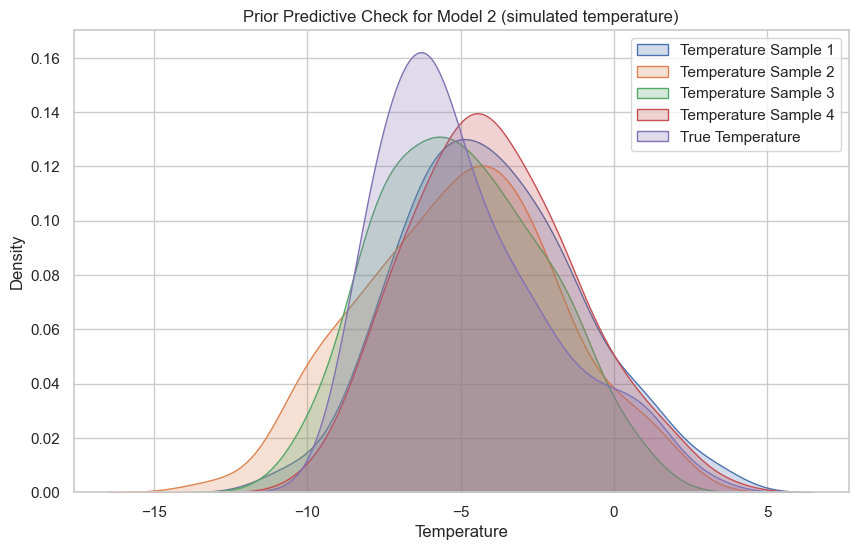

In [24]:
# Simulate
# np.random.seed(0)
simulation_result2 = simulate_joint_mod2(data['co2'], num=4)

# Plot the realized temperature samples
plt.figure(figsize=(10, 6))
for i,tmp_sample_i in enumerate(simulation_result2['tmp_samples']):
    sns.kdeplot(tmp_sample_i, label=f'Temperature Sample {i + 1}', fill=True)
    
sns.kdeplot(data['tmp'], label='True Temperature', fill=True)
plt.title('Prior Predictive Check for Model 2 (simulated temperature)')
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.legend()
plt.show()

In [25]:
# Determine relevant statistics of the simulated temperature and comparing them 
# to those of the true observed temperature

simulated_data_n1 = simulation_result2['tmp_samples'][0]
simulated_data_n2 = simulation_result2['tmp_samples'][1]
simulated_data_n3 = simulation_result2['tmp_samples'][2]
true_data_tmp = data['tmp']

simulated_data_list = [simulated_data_n1, simulated_data_n2,simulated_data_n3, true_data_tmp]

# List to store results
results = []

# Loop over each set of simulated data
for i, simulated_data in enumerate(simulated_data_list, start=1):
    mean_i = np.mean(simulated_data)
    mode_i = mode(simulated_data, axis=None).mode[0]
    skewness_i = skew(simulated_data)
    std_i = np.std(simulated_data)
    kurtosis_i = kurtosis(simulated_data)

    # Append results to the list
    results.append({
        'n': i,
        'mean': mean_i,
        'mode': mode_i,
        'skewness': skewness_i,
        'std': std_i,
        'kurtosis': kurtosis_i
    })

# Print results
for result in results:
    print(f"\nStats for n={result['n']} samples:")
    print(f"Mean: {result['mean']}, Mode: {result['mode']}, Skewness: {result['skewness']}, Std: {result['std']}, Kurtosis: {result['kurtosis']}")


Stats for n=1 samples:
Mean: -4.011819168109788, Mode: -10.900552815804055, Skewness: 0.2597937046985207, Std: 2.8789249203742693, Kurtosis: -0.21472882965975648

Stats for n=2 samples:
Mean: -4.973101445070323, Mode: -13.224405158858698, Skewness: -0.0232232164547783, Std: 3.120578273264285, Kurtosis: -0.43320920669294694

Stats for n=3 samples:
Mean: -4.995756017770994, Mode: -11.033554847535315, Skewness: 0.18143854090556585, Std: 2.6419961548352826, Kurtosis: -0.6354701056401151

Stats for n=4 samples:
Mean: -4.84375, Mode: -5.74, Skewness: 0.8013453272799188, Std: 2.7246538197539887, Kurtosis: -0.08670314264966805


 When n = 3 we get the relevant statistics (mode, mean, kurtosis, standard deviation and skewness) which are close to those of the true observed temperature. Those gotten when n = 1 or n = 2 are not far away off either.

With model 2 : 

Let's start by defining the full joint probability distribution: 

$P((x,y), \beta_0,\beta_1, \sigma^2, \rho, ... , \rho^{N-1} ) = P(\beta_0) \cdot P(\beta_1) \cdot \prod_{i=1}^{N-1}P(\rho^i) \cdot P(\sigma^2) \cdot P((x,y)|\beta_0,\beta_1, \sigma^2, \rho, ... , \rho^{N-1})$.

We get interesting relevent statistics which around of those of the true observed temperature like those gotten in the prior predictive 1.

# Compute: Posterior inference

Repeat Q6, Q7 and Q8 for both models.

<div class="alert alert-success">
    
**Q6**. Compute the posterior distribution of all unobserved random variables. 
    
Tips: If you use MCMC, initialize the chain(s) around the MAP estimate.
    
</div>

 For the model 1:  MCMC
The choice of initial values of the parameter have been explained in the answer2.

In [163]:
np.random.seed(37)
# Define the log prior function
def log_prior_mod1(theta, data):
    prior_beta_0 = norm.logpdf(theta[0], loc=-23, scale=1)
    prior_beta_1 = norm.logpdf(theta[1], loc=0.08, scale=1e-3)
    prior_sigma_2 = gamma.logpdf(theta[2], a=1, scale=data['tmp'].var()/3)
    
    return prior_beta_0 + prior_beta_1 + prior_sigma_2

# Define the log likelihood function
def log_likelihood_mod1(theta, x, y):
    n = len(x)
    mean = theta[0] + theta[1] * x
    covariance = theta[2] * np.eye(n)
    
    # Ensure the covariance matrix is positive definite
    try:
        likelihoods = multivariate_normal.logpdf(y, mean=mean, cov=covariance)
    except np.linalg.LinAlgError as e:
        print(f"LinAlgError: {e}")
        return -np.inf  # Return a very low log-likelihood if there's an issue
    
    return np.sum(likelihoods)

# Define the MAP log likelihood function
def map_log_likelihood_mod1(theta, x, y, data):
    log_likelihood = log_likelihood_mod1(theta, x, y)
    log_prior = log_prior_mod1(theta, data)
    
    if np.isnan(log_likelihood) or np.isinf(log_likelihood):
        print(f"Invalid log_likelihood: {log_likelihood} for theta: {theta}")
        return np.inf  # Return a very high negative value if log_likelihood is invalid
    
    if np.isnan(log_prior) or np.isinf(log_prior):
        print(f"Invalid log_prior: {log_prior} for theta: {theta}")
        return np.inf  # Return a very high negative value if log_prior is invalid
    
    return -log_likelihood - log_prior
# Initial value for each parameter
initial1 = [norm(-23.16, 1).rvs(), uniform(0.08, 1e-3).rvs(), gamma(1,data['tmp'].var()/3).rvs()]

# Minimize the map_log_likelihood function
result1 = minimize(map_log_likelihood_mod1, initial1, args=(data['co2'], data['tmp'], data))
result1

      fun: 364.9920256974836
 hess_inv: array([[ 6.25603640e-02, -2.21927113e-04, -1.30455619e-03],
       [-2.21927113e-04,  9.68415818e-07,  5.01515207e-06],
       [-1.30455619e-03,  5.01515207e-06,  5.28391421e-02]])
      jac: array([ 0.00000000e+00,  0.00000000e+00, -3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 76
      nit: 12
     njev: 19
   status: 0
  success: True
        x: array([-23.05231039,   0.07997928,   2.30499617])

For the model 1, the posterior probability density function of the parameters $\beta_0$, $\beta_1$ and $\sigma^2$ given the observaed data (x,y):

$$\log(P(\beta_0, \beta_1, \sigma^2| (x, y)) \propto 
\log(P(\beta_0)) + \log(P(\beta_1)) + \log(P(\sigma^2)) + \log(P((x,y) |\beta_0, \beta_1, \sigma^2))$$


In [166]:
# Determining the log_posterior p((x,y)|theta)
def log_posterior_mod1(theta, x, y, data):
    lp = log_prior_mod1(theta, data)
    if not np.isfinite(lp):
        return -np.inf
    return log_likelihood_mod1(theta,x,y) + lp

In [167]:
nwalkers1, ndim1 = 30, len(initial1)
pos1 = result1.x + 0.01 * np.random.randn(nwalkers1, ndim1)

In [168]:
sampler1 = emcee.EnsembleSampler(nwalkers1, ndim1, log_posterior_mod1, args=(data['co2'],data['tmp'], data))
sampler1.run_mcmc(pos1, 5000 , progress=True);

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [39:51<00:00,  2.09it/s]


For the model 2, the posterior probability density function of the parameters $\beta_0$, $\beta_1$,  $\rho,..., \rho^{N-1}$ and $\sigma^2$ given the observaed data (x,y)

$$\log(P(\beta_0, \beta_1, \sigma^2, \rho,..., \rho^{N-1}| (x, y)) \propto 
\log(P(\beta_0)) + \log(P(\beta_1)) + \log(P(\sigma^2)) + \sum_{i=1}^{N-1} \log(P(\rho^i))
 + \log(P((x,y) |\beta_0, \beta_1, \sigma^2, \rho,..., \rho^{N-1}))$$


In [165]:
np.random.seed(11)
# Determine the log_prior p(theta)
def log_prior_mod2(theta, data):
    N = len(data)
    prior_beta_0 = norm.logpdf(theta[0], loc=-23, scale=1)
    prior_beta_1 = norm.logpdf(theta[1], loc=0.08, scale=1e-3)
    prior_sigma_2 = gamma.logpdf(theta[2], 1, scale=data['tmp'].var()/5)
    prior_rho_sum = sum(uniform.logpdf(theta[3] ** i, -0.990, 1.99) for i in range(1, N))
    
    return prior_beta_0 + prior_beta_1 + prior_sigma_2 + prior_rho_sum

# Determine the log-likelihood
def log_likelihood_mod2(theta, x, y):
    n = len(x)
    rho = theta[3]

    # Generate correlated Gaussian noise
    cov_matrix = np.array([[rho**abs(i - j) if i != j else 1 for i in range(n)] for j in range(n)])

    # Check and print a warning if rho is outside the range ]-1, 1[
    if not (-1 < rho < 1):
        print("Warning: rho value is outside the range ]-1, 1[.")
    
    # Calculate the log-likelihood
    log_likelihoods = multivariate_normal.logpdf(y, mean=theta[0] + theta[1] * x , cov=theta[2] * cov_matrix)
    
    # Sum the log-probabilities to get the total log-likelihood
    return np.sum(log_likelihoods)

# Determine the MAP estimate
def map_log_likelihood_mod2(theta, x, y, data):
    return -log_likelihood_mod2(theta, x, y) - log_prior_mod2(theta, data)

# Initial value for each model parameter
initial2 =  [norm(-23, 1).rvs(), uniform(0.08, 1e-3).rvs(), gamma(1 , data['tmp'].var()/5).rvs(), uniform(-0.99, 1.98).rvs()]

# Minimize the map_log_likelihood function
result2 = minimize(map_log_likelihood_mod2, initial2, args=(data['co2'], data['tmp'], data))
result2

      fun: 470.80495063110004
 hess_inv: array([[ 7.26429599e-02, -1.87092979e-04,  2.74994879e-03,
         1.15904098e-03],
       [-1.87092979e-04,  8.63486109e-07, -2.03217368e-06,
        -3.61289827e-06],
       [ 2.74994879e-03, -2.03217368e-06,  7.86497976e-02,
         9.80426655e-03],
       [ 1.15904098e-03, -3.61289827e-06,  9.80426655e-03,
         3.59373462e-03]])
      jac: array([-7.62939453e-06,  0.00000000e+00,  7.62939453e-06,  7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 295
      nit: 51
     njev: 59
   status: 0
  success: True
        x: array([-22.92324447,   0.07944523,   2.2655969 ,   0.51185866])

In [169]:
# Determining the log_posterior p((x,y)|theta)
def log_posterior_mod2(theta, x, y, data):
    lp = log_prior_mod2(theta, data)
    if not np.isfinite(lp):
        return -np.inf
    return log_likelihood_mod2(theta,x,y) + lp

In [170]:
nwalkers2, ndim2 = 30, len(initial2)
pos2 = result2.x + 0.01 * np.random.randn(nwalkers2, ndim2)

In [171]:
sampler2 = emcee.EnsembleSampler(nwalkers2, ndim2, log_posterior_mod2, args=(data['co2'],data['tmp'],data))
sampler2.run_mcmc(pos2, 5000, progress=True);

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:49:31<00:00,  1.31s/it]


<div class="alert alert-success">
    
**Q7**. Assess whether your inference results are computationally faithful (check the convergence, mixing, and autocorrelation of the chains).
    
</div>

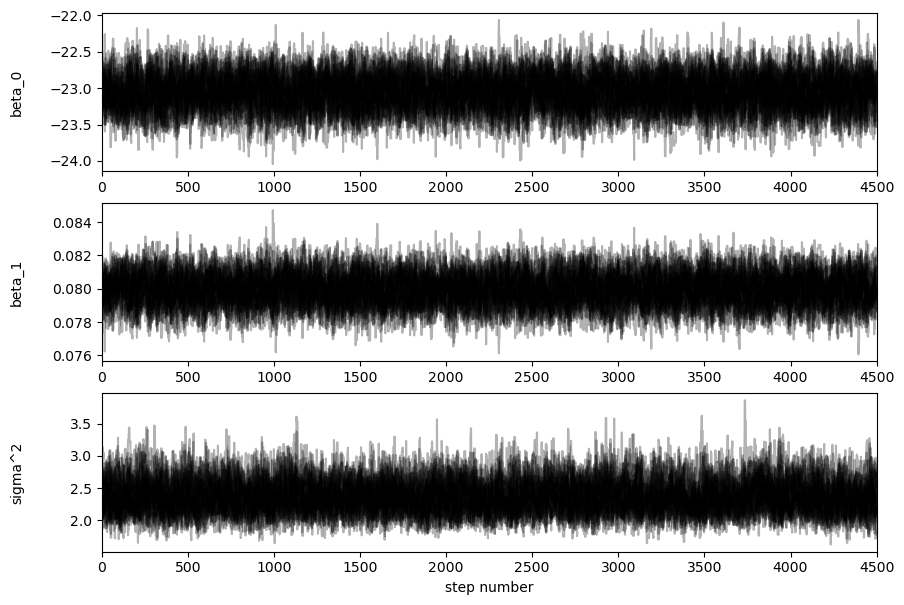

In [172]:
labels1 = ["beta_0", "beta_1", "sigma^2"]

fig, axes = plt.subplots(3, figsize=(10, 7))
thetas1 = sampler1.get_chain(discard=500)

for i in range(3):
    ax = axes[i]
    ax.plot(thetas1[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(thetas1))
    ax.set_ylabel(labels1[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.grid(False)

axes[-1].set_xlabel("step number")
plt.show()

We note that the estimated values of the model parameters of model 1 all cover a precise interval over the iterations: $\beta_0$, $\beta_1$, $\sigma^2$ $\in$ ]-24;-22.2[ x ]0.075;0.09[ x ]2.5;4[ . 

In [173]:
tau1 = sampler1.get_autocorr_time()
tau1

array([36.7660672 , 34.25534386, 41.36780904])

For each estimated parameter, we cover an average 38 samples for finding one independent sample. This is due to the fact the autocorrelation values determined, are low. Thereby the chains are stabilized and explore sufficiently good the intervals mentioned previously and converge towards the posterior distribution of each parameter. That yields a good mixing. We can visualize them through the trace plots of the chain samples. 

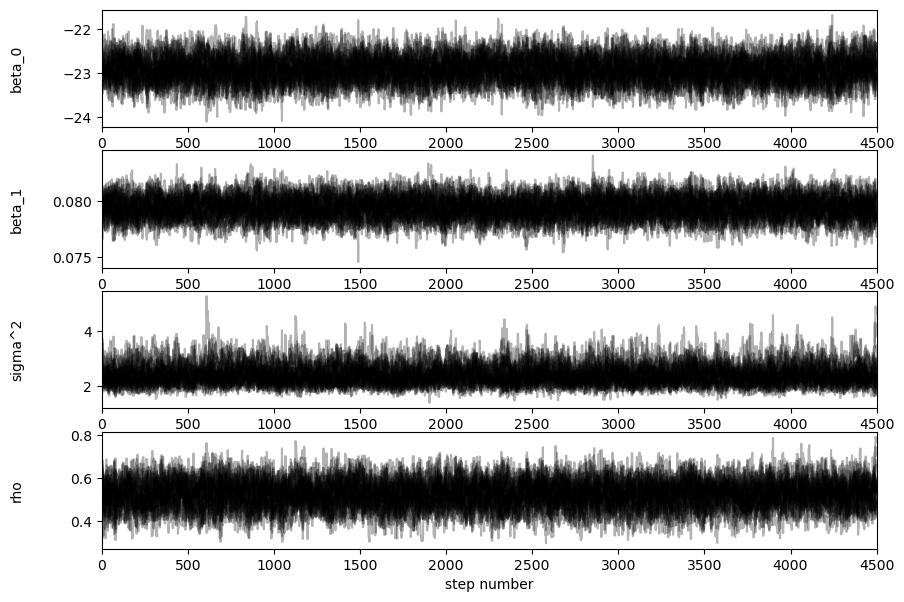

In [174]:
# Model 2: 
labels2 = ["beta_0", "beta_1", "sigma^2","rho"]

fig, axes = plt.subplots(4, figsize=(10, 7))
thetas2 = sampler2.get_chain(discard=500)

for i in range(4):
    ax = axes[i]
    ax.plot(thetas2[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(thetas2))
    ax.set_ylabel(labels2[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.grid(False)

axes[-1].set_xlabel("step number")
plt.show()

We note that the estimated values of the model parameters of model 1 all cover a precise interval over the iterations: $\beta_0$, $\beta_1$, $\sigma^2$, $\rho$ $\in$ ]-24;-22.5[ x ]0.075;0.12[ x ]1.5;5[ x ]0;0.8[ .

In [175]:
tau2 = sampler2.get_autocorr_time()
tau2

array([44.67034406, 42.16772852, 45.89513658, 44.78963253])

For each estimated parameter, we cover an average 43 samples for finding one independent sample. This is due to the fact the autocorrelation values determined, are low. Thereby the chains are stabilized and explore sufficiently good the intervals mentioned previously and converge towards the posterior distribution of each parameter. That yields a good mixing. We can visualize them through the trace plots of the chain samples. 

<div class="alert alert-success">
    
**Q8**. Plot the posterior distributions and discuss the results.
    
</div>

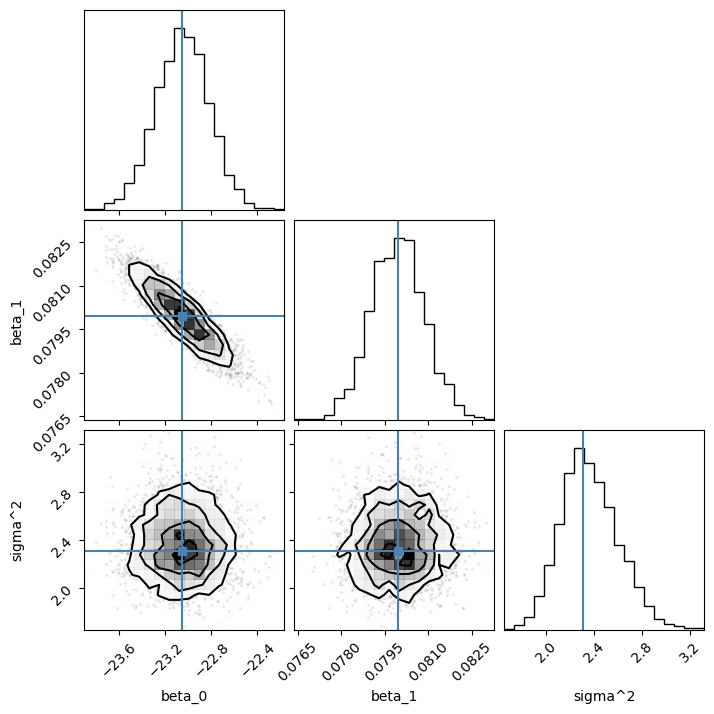

In [176]:
# For the model 1: 
theta_true1 = result1.x
thetas1 = sampler1.get_chain(flat=True, discard=200, thin=45)
thetas1_ = sampler1.get_chain(flat=True)
fig = corner.corner(thetas1, labels=labels1, truths = theta_true1)

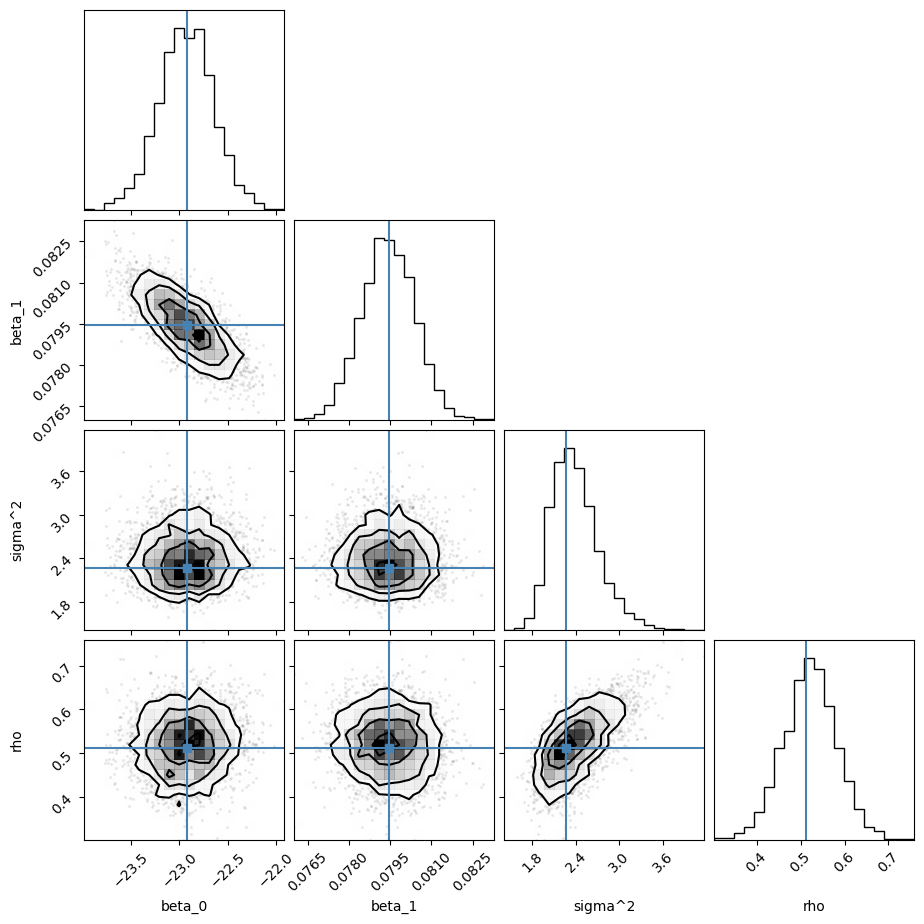

In [177]:
# For the model 2:
theta_true2 = result2.x
thetas2 = sampler2.get_chain(flat=True, discard=200, thin=45)
thetas2_ = sampler2.get_chain(flat=True)
fig = corner.corner(thetas2, labels=labels2, truths=theta_true2)

# Criticize

<div class="alert alert-success">
    
**Q9**. Compare the posterior predictive distributions of replicated data $\{y^\text{rep}\}$ for  Model 1 and Model 2. Discuss each in comparison to the distribution of the data measurements.
    
</div>

In [40]:
# Posterior predictive distribution (model 1)

def pp1(x, num, thetas):
    # Permute parameter values
    permuted_indices = np.random.permutation(len(thetas))[:num]

    # Set the estimated posterior distributions
    beta_0_post = thetas[permuted_indices, 0]
    beta_1_post = thetas[permuted_indices, 1] 
    sigma_2_post = thetas[permuted_indices, 2]

    # Simulate temperature samples
    y_samples = []

    for i in range(num):
        # Simulate joint distribution of all parameters
        theta_i = [beta_0_post[i], beta_1_post[i], sigma_2_post[i]]

        # Simulate temperature samples using the provided simulation function
        y_sample_i = simulate_mod1(x, theta_i)
        y_samples.append(y_sample_i)
           
    return {'y_samples': np.array(y_samples)}

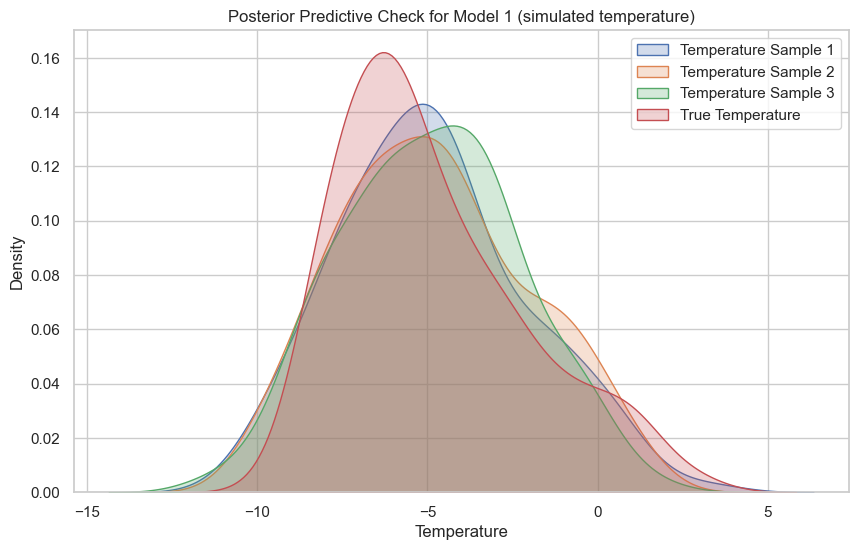

In [41]:
# Visual inspection of the posterior predictive distribution
np.random.seed(1)
simulation_result = pp1(data['co2'], num=3, thetas =thetas1)  

# Plot the realized temperature samples
plt.figure(figsize=(10, 6))
for i, tmp_sample_i in enumerate(simulation_result['y_samples']):
    sns.kdeplot(tmp_sample_i, label=f'Temperature Sample {i + 1}', fill=True)
    
sns.kdeplot(data['tmp'], label='True Temperature', fill=True)
plt.title('Posterior Predictive Check for Model 1 (simulated temperature)')
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.legend()
plt.show()

In [42]:
# Posterior predictive distribution (model 2)

def pp2(x, num, thetas):
    # Permute parameter values
    permuted_indices = np.random.permutation(len(thetas))[:num]

    # Set the estimated posterior distributions
    beta_0_post = thetas[permuted_indices, 0]
    beta_1_post = thetas[permuted_indices, 1] 
    sigma_2_post = thetas[permuted_indices, 2]
    rho_2_post = thetas[permuted_indices, 3]

    # Simulate temperature samples
    y_samples = []

    for i in range(num):
        # Simulate joint distribution of all parameters
        theta_i = [beta_0_post[i], beta_1_post[i], sigma_2_post[i], rho_2_post[i]]

        # Simulate temperature samples using the provided simulation function
        y_sample_i = simulate_mod2(x, theta_i)
        y_samples.append(y_sample_i)
           
    return {'y_samples': np.array(y_samples)}

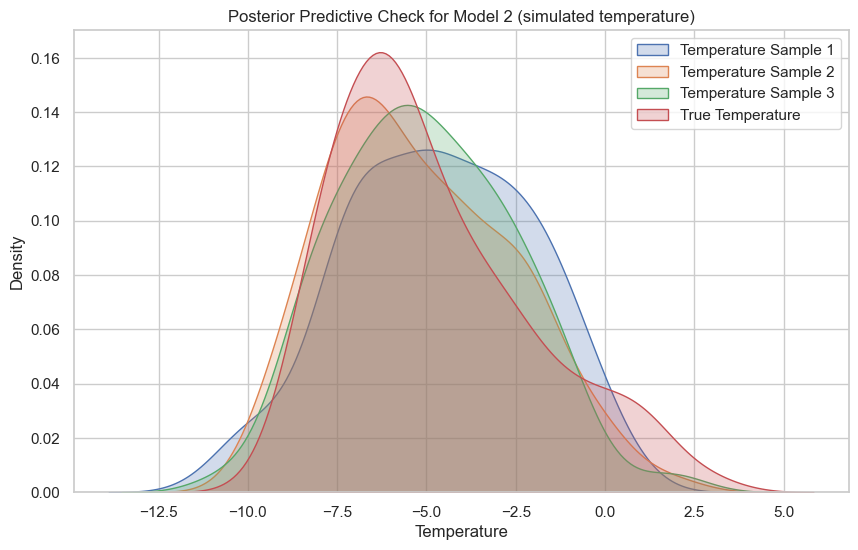

In [43]:
# Visual inspection of the posterior predictive distribution
np.random.seed(1)
simulation_result = pp2(data['co2'], num=3, thetas =thetas2)  

# Plot the realized temperature samples
plt.figure(figsize=(10, 6))
for i, tmp_sample_i in enumerate(simulation_result['y_samples']):
    sns.kdeplot(tmp_sample_i, label=f'Temperature Sample {i + 1}', fill=True)
    
sns.kdeplot(data['tmp'], label='True Temperature', fill=True)
plt.title('Posterior Predictive Check for Model 2 (simulated temperature)')
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.legend()
plt.show()

From a visual perspective, it is evident that the simulated temperature distribution curves closely resemble the real distribution, especially those produced by the model. The discrepancies observed are slightly smaller in terms of mode and asymmetry.

In [44]:
def compute_mse(model_func, x, y, num_samples, thetas):
    posterior_samples = model_func(x, num_samples,thetas)['y_samples']
    mse_list = []
    for i in range(num_samples):
        predicted_tmp = posterior_samples[i]  
        mse = mean_squared_error(y, predicted_tmp)
        mse_list.append(mse)
    return mse_list

num = thetas1.shape[0]
# Model 2
mse_model2 = compute_mse(pp1, data['co2'], data['tmp'].values, num, thetas2)
average_mse_model2 = sum(mse_model2) / len(mse_model2)

# Model 1
mse_model1 = compute_mse(pp1, data['co2'], data['tmp'].values, num, thetas1)
average_mse_model1 = sum(mse_model1) / len(mse_model1)

# Print average MSEs
print(f"Average Mean Squared Error for Model 1: {average_mse_model1}")
print(f"Average Mean Squared Error for Model 2: {average_mse_model2}")

# Compare the averages
if average_mse_model1 < average_mse_model2:
    print("Model 1 has lower average MSE, indicating better performance.")
elif average_mse_model1 > average_mse_model2:
    print("Model 2 has lower average MSE, indicating better performance.")
else:
    print("Both models have the same average MSE.")

Average Mean Squared Error for Model 1: 4.98524969255127
Average Mean Squared Error for Model 2: 4.725765656787867
Model 2 has lower average MSE, indicating better performance.


The MSE we calculate represents the $bias^2$ ; the higher it is, the poorer the model. 
According to the previous results, the posterior predictive distributions of replicated data of the model 2 is better than the one of model 1.

<div class="alert alert-success">
    
**Q10**. Compare and discuss the posterior predictive distributions of test quantities of replicated data for Model 1 and Model 2. 
    
</div>

Test quantities chosen, are the mean and standard deviation, for discussing about the posterior predictive distributions yielding the replicated data gotten with the models 1 and 2.

In [45]:
# Mean and standard deviation of the true temperature
print("Empirical mean =", np.mean(data['tmp']))
print("Empirical std =", np.std(data['tmp']))

Empirical mean = -4.84375
Empirical std = 2.7246538197539887


In [46]:
# Posterior predictive distribution (Model 1):
print("Model 1 : E_p(beta_0|x)[beta_0] =", np.mean(thetas1[:, 0]))
print("Model 1 : E_p(beta_1|x)[beta_1] =", np.mean(thetas1[:, 1]))
print("Model 1  : E_p(sigma_2|x)[sigma_2] =", np.mean(thetas1[:, 2]))
print()

# Posterior predictive distribution (Model 2):
print("Model 2 : E_p(beta_0|x)[beta_0] =", np.mean(thetas2[:, 0]))
print("Model 2 : E_p(beta_1|x)[beta_1] =", np.mean(thetas2[:, 1]))
print("Model 2 : E_p(sigma_2|x)[sigma_2] =", np.mean(thetas2[:, 2]))

Model 1 : E_p(beta_0|x)[beta_0] = -23.056224432262827
Model 1 : E_p(beta_1|x)[beta_1] = 0.07999381638932862
Model 1  : E_p(sigma_2|x)[sigma_2] = 2.646924994677474

Model 2 : E_p(beta_0|x)[beta_0] = -22.92946338749934
Model 2 : E_p(beta_1|x)[beta_1] = 0.07947321558490997
Model 2 : E_p(sigma_2|x)[sigma_2] = 2.365966558195488


The empirical values of these parameters in the models 1 and 2 are close.

In [47]:
for num in range(1,51):
    result = pp1(data['co2'], num=num, thetas=thetas1)
    mean_value = np.mean(result['y_samples'])
    print(f"For num = {num}, Mean of the simulated obtained is: {mean_value} with model 1")

For num = 1, Mean of the simulated obtained is: -4.887051376732071 with model 1
For num = 2, Mean of the simulated obtained is: -4.795485000307736 with model 1
For num = 3, Mean of the simulated obtained is: -4.823028357432115 with model 1
For num = 4, Mean of the simulated obtained is: -4.676793635927174 with model 1
For num = 5, Mean of the simulated obtained is: -4.757624059446441 with model 1
For num = 6, Mean of the simulated obtained is: -4.832793394108753 with model 1
For num = 7, Mean of the simulated obtained is: -4.8716594777123206 with model 1
For num = 8, Mean of the simulated obtained is: -4.890544507575435 with model 1
For num = 9, Mean of the simulated obtained is: -4.843066198924134 with model 1
For num = 10, Mean of the simulated obtained is: -4.7808806961585235 with model 1
For num = 11, Mean of the simulated obtained is: -4.845741537963634 with model 1
For num = 12, Mean of the simulated obtained is: -4.908745644345012 with model 1
For num = 13, Mean of the simulated

One can see that the temperature average values obtained from replicated data of the model 1 are close to the true temperature average value.

In [48]:
for num in range(1,51):
    result = pp2(data['co2'], num=num, thetas=thetas2)
    mean_value = np.mean(result['y_samples'])
    print(f"For num = {num}, Mean of the simulated obtained is: {mean_value} with model 2")

For num = 1, Mean of the simulated obtained is: -4.608610377108954 with model 2
For num = 2, Mean of the simulated obtained is: -4.835010315298745 with model 2
For num = 3, Mean of the simulated obtained is: -4.584400744967872 with model 2
For num = 4, Mean of the simulated obtained is: -4.818109550627522 with model 2
For num = 5, Mean of the simulated obtained is: -5.010518907801066 with model 2
For num = 6, Mean of the simulated obtained is: -4.781175876151524 with model 2
For num = 7, Mean of the simulated obtained is: -4.650880516991435 with model 2
For num = 8, Mean of the simulated obtained is: -4.777631363676417 with model 2
For num = 9, Mean of the simulated obtained is: -4.71139016000422 with model 2
For num = 10, Mean of the simulated obtained is: -4.8609988694963615 with model 2
For num = 11, Mean of the simulated obtained is: -4.9700621529650295 with model 2
For num = 12, Mean of the simulated obtained is: -4.686742742419038 with model 2
For num = 13, Mean of the simulated 

One can see that the temperature average values obtained from replicated data of the model 2 are also close to the true temperature average value.

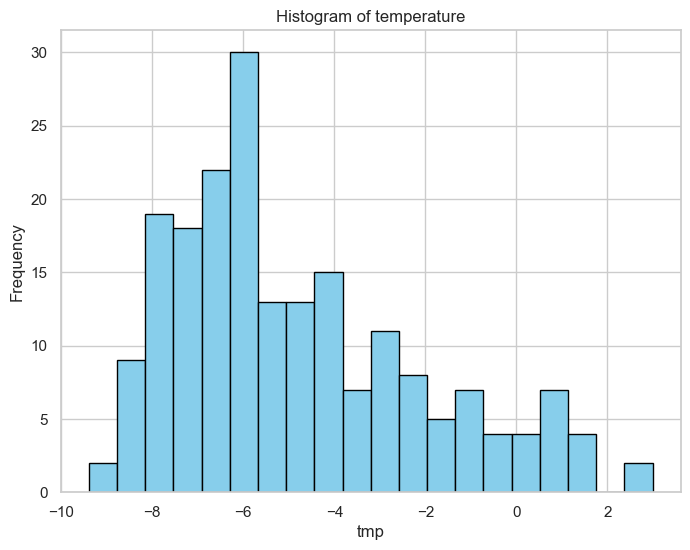

In [49]:
# Visual inspection of the posterior predictive distribution
plt.figure(figsize=(8, 6))
plt.hist(data['tmp'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of temperature')
plt.xlabel('tmp')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

For num = 2, Mean of the simulated obtained is: -4.957392004501416 with model 1
For num = 2, Standard deviation of the simulated obtained is: 2.8115288080935925 with model 1

For num = 3, Mean of the simulated obtained is: -4.755832675483395 with model 1
For num = 3, Standard deviation of the simulated obtained is: 2.816741135793267 with model 1

For num = 4, Mean of the simulated obtained is: -4.950204531840987 with model 1
For num = 4, Standard deviation of the simulated obtained is: 2.780943139471973 with model 1

For num = 5, Mean of the simulated obtained is: -4.849140854957745 with model 1
For num = 5, Standard deviation of the simulated obtained is: 2.7967417786215907 with model 1

For num = 6, Mean of the simulated obtained is: -4.949242590814016 with model 1
For num = 6, Standard deviation of the simulated obtained is: 2.7911453763486325 with model 1

For num = 7, Mean of the simulated obtained is: -4.868304456206496 with model 1
For num = 7, Standard deviation of the simulate

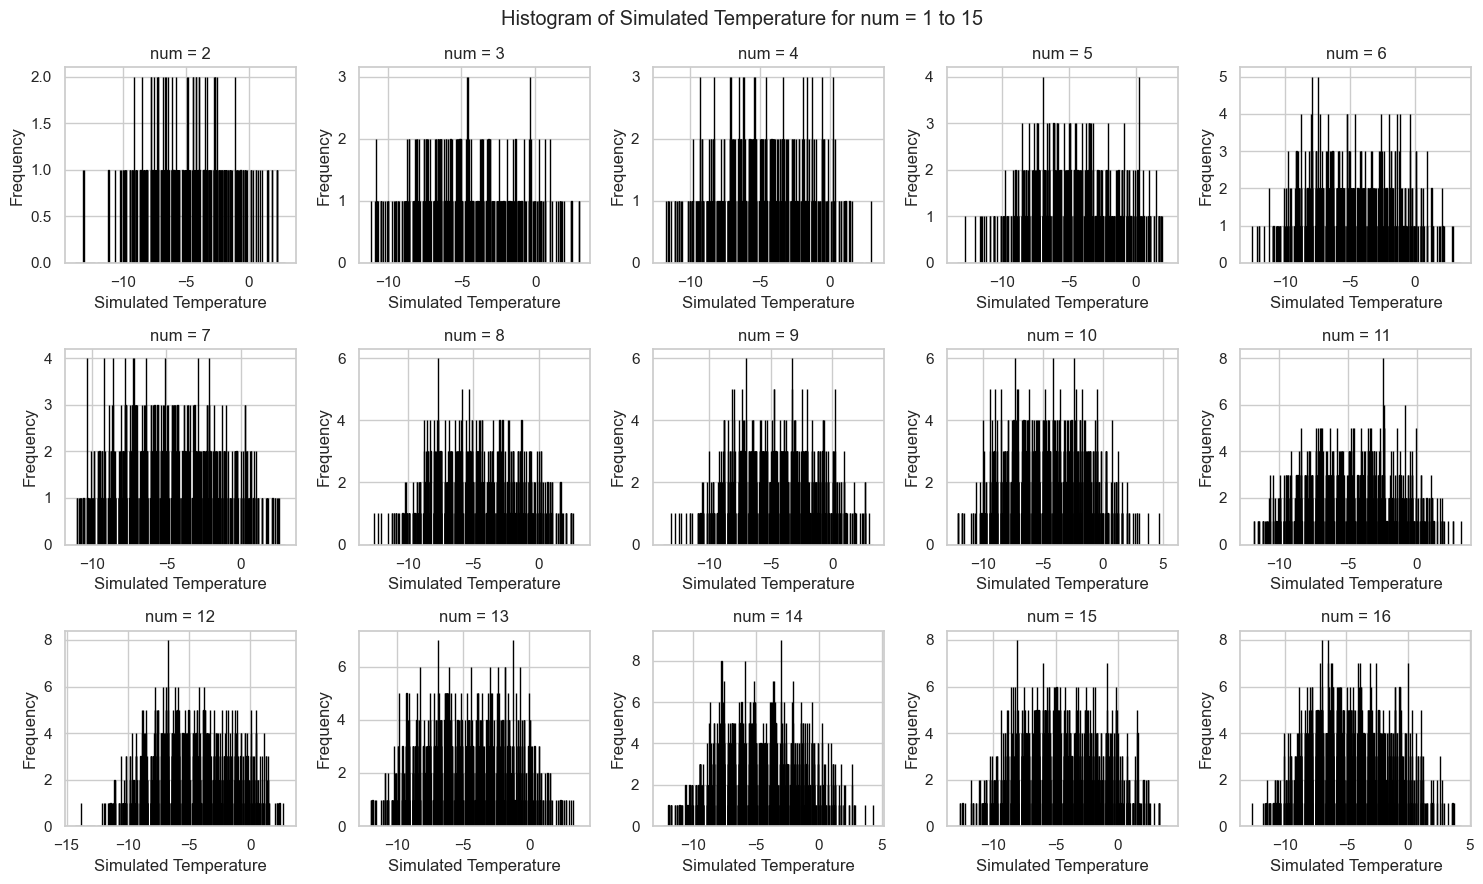

In [50]:
# Create a 3x5 grid of subplots
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Histogram of Simulated Temperature for num = 1 to 15')

# Counter for tracking the position in the grid
row, col = 0, 0

# Loop through the first 15 num values
for num in range(2, 17):
    # Perform simulation and compute mean
    result = pp1(data['co2'], num=num, thetas=thetas1)
    mean_value = np.mean(result['y_samples'])
    std_value = np.std(result['y_samples'])
    
    # Print mean value
    print(f"For num = {num}, Mean of the simulated obtained is: {mean_value} with model 1")
    print(f"For num = {num}, Standard deviation of the simulated obtained is: {std_value} with model 1")
    print()
    
    # Plot histogram without specifying color
    axes[row, col].hist(result['y_samples'], bins=20, edgecolor='black')
    axes[row, col].set_title(f'num = {num}')
    axes[row, col].set_xlabel('Simulated Temperature')
    axes[row, col].set_ylabel('Frequency')
    
    # Move to the next subplot position
    col += 1
    if col == 5:
        row += 1
        col = 0

# Adjust layout and display plot
plt.tight_layout()
plt.show()

For num = 2, Mean of the simulated obtained is: -4.762899025018765 with model 2
For num = 2, Standard deviation of the simulated obtained is: 2.842205680758909 with model 2

For num = 3, Mean of the simulated obtained is: -4.885898389053717 with model 2
For num = 3, Standard deviation of the simulated obtained is: 2.6348268858372474 with model 2

For num = 4, Mean of the simulated obtained is: -4.792688648945075 with model 2
For num = 4, Standard deviation of the simulated obtained is: 2.664819195267416 with model 2

For num = 5, Mean of the simulated obtained is: -4.981047492632363 with model 2
For num = 5, Standard deviation of the simulated obtained is: 2.709649062309834 with model 2

For num = 6, Mean of the simulated obtained is: -4.605550157482637 with model 2
For num = 6, Standard deviation of the simulated obtained is: 2.8331502477257673 with model 2

For num = 7, Mean of the simulated obtained is: -4.777083911028658 with model 2
For num = 7, Standard deviation of the simulated

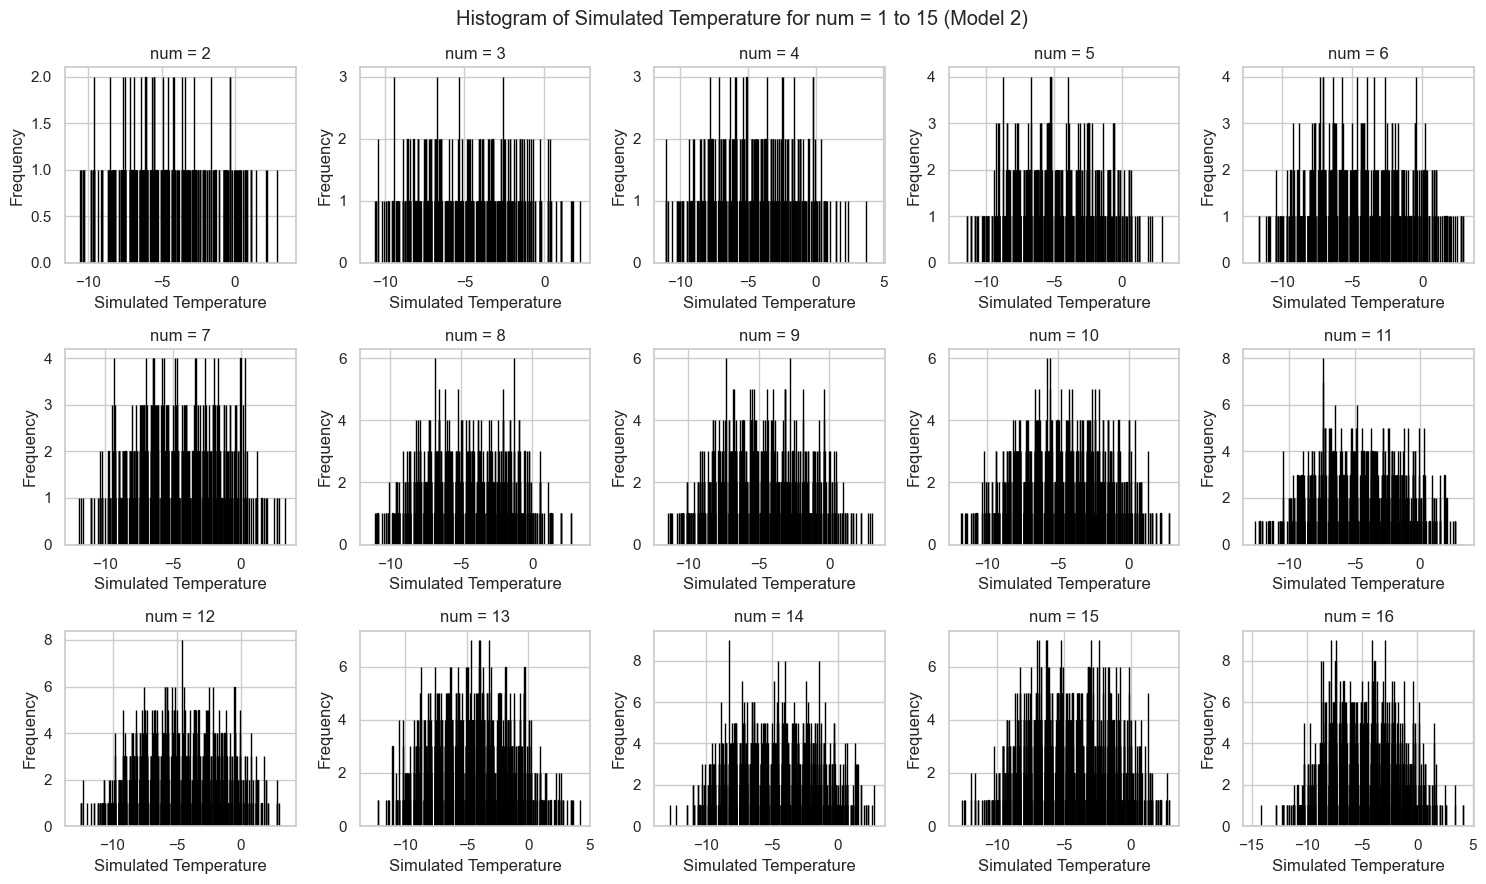

In [51]:
# Create a 3x5 grid of subplots
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Histogram of Simulated Temperature for num = 1 to 15 (Model 2)')

# Counter for tracking the position in the grid
row, col = 0, 0

# Loop through the first 15 num values
for num in range(2, 17):
    # Perform simulation and compute mean
    result = pp2(data['co2'], num=num, thetas=thetas2)
    mean_value = np.mean(result['y_samples'])
    std_value = np.std(result['y_samples'])
    
    # Print mean value
    print(f"For num = {num}, Mean of the simulated obtained is: {mean_value} with model 2")
    print(f"For num = {num}, Standard deviation of the simulated obtained is: {std_value} with model 2")
    print()

    # Plot histogram without specifying color
    axes[row, col].hist(result['y_samples'], bins=20, edgecolor='black')
    axes[row, col].set_title(f'num = {num}')
    axes[row, col].set_xlabel('Simulated Temperature')
    axes[row, col].set_ylabel('Frequency')
    
    # Move to the next subplot position
    col += 1
    if col == 5:
        row += 1
        col = 0

# Adjust layout and display plot
plt.tight_layout()
plt.show()

In term of standard deviation, the replicated data obtained with models 1 and 2 are also close to the true standard deviation.

<div class="alert alert-success">
    
**Q11**. Evaluate the posterior predictive performance of Model 1 and Model 2.

</div>

We will rely on the cross-validation and the expected log predictive density for this assessment.

In [178]:
# Define the function to calculate log-posterior predictive density for model 1
def log_posterior_predictive_mod1(x, y, thetas):
    log_pred_densities = [log_likelihood_mod1(theta, x, y) for theta in thetas]
    return np.mean(log_pred_densities)

# Define the function to calculate ELPD for model 1
def elpd1(xs, thetas):
    x, y = xs['co2'], xs['tmp']
    return log_posterior_predictive_mod1(x, y, thetas)

In [179]:
# Define the number of splits
n_splits = 5

# Initialize KFold without shuffling
kf = KFold(n_splits=n_splits, shuffle=False)

elpd_test1 = []

for train_idx, test_idx in kf.split(data):
    # Prepare training and testing data
    train_set = data.iloc[train_idx]
    test_set = data.iloc[test_idx]
    
    # Posterior fit
    nwalkers1, ndim1 = 30, len(initial1)
    pos1 = initial1 + 0.001 * np.random.randn(nwalkers1, ndim1)
    sampler1 = emcee.EnsembleSampler(nwalkers1, ndim1, log_posterior_mod1, 
                                     args=(train_set['co2'].values, train_set['tmp'].values, train_set))
    sampler1.run_mcmc(pos1, 5000, progress=True)
    thetas1 = sampler1.get_chain(flat=True, discard=500)
    
    # Calculate ELPD for the current fold
    subset = np.random.permutation(len(thetas1))[:500]
    elpd_test_fold = elpd1(test_set, thetas1[subset])
    elpd_test1.append(elpd_test_fold)

# Calculate average ELPD across all folds
average_elpd = np.mean(elpd_test1)
print("Average ELPD for modified model 1 (across folds):", average_elpd)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [24:15<00:00,  3.44it/s]


Average ELPD for modified model 1 (across folds): -74.48675136187772


In [180]:
elpd_test1

[-72.49188764572071,
 -82.64477178096483,
 -74.88599418171619,
 -73.002383954377,
 -69.40871924660992]

In [181]:
print("Average ELPD for model 1 (across folds):", np.mean(elpd_test1))
print("Standard deviation ELPD for model 1 (across folds):", np.std(elpd_test1))

Average ELPD for model 1 (across folds): -74.48675136187772
Standard deviation ELPD for model 1 (across folds): 4.442565249889215


In [182]:
# Define the function to calculate log-posterior predictive density for model 1
def log_posterior_predictive_mod2(x, y, thetas):
    log_pred_densities = [log_likelihood_mod2(theta, x, y) for theta in thetas]
    return np.mean(log_pred_densities)

# Define the function to calculate ELPD for model 2
def elpd2(xs, thetas):
    x, y = xs['co2'], xs['tmp']
    return log_posterior_predictive_mod2(x, y, thetas)

In [183]:
# Initialize an empty list to store the elpd values
elpd_test2 = []

# Apply 5-cross-validation without shuffling the data
for train_idx, test_idx in kf.split(data):
    # posterior fit
    nwalkers2, ndim2 = 30, len(initial2)
    pos2 = result2.x + 0.001 * np.random.randn(nwalkers2, ndim2)
    sampler2 = emcee.EnsembleSampler(nwalkers2, ndim2, log_posterior_mod2, args=(train_set['co2'], train_set['tmp'], train_set))
    sampler2.run_mcmc(pos2, 5000, progress=True)
    thetas2 = sampler2.get_chain(flat=True)
    
    # epld
    subset = np.random.permutation(len(thetas2))[:500]
    elpd_test2.append(elpd2(data.iloc[test_idx], thetas2[subset])) 

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:09:45<00:00,  1.19it/s]


In [184]:
elpd_test2

[-58.57968198978134,
 -71.30751307235897,
 -74.61551861055804,
 -63.99965177435871,
 -69.75399762101969]

In [185]:
print("Average ELPD for model 2 (across folds):", np.mean(elpd_test2))
print("Standard deviation ELPD for model 2 (across folds):", np.std(elpd_test2))

Average ELPD for model 2 (across folds): -67.65127261361536
Standard deviation ELPD for model 2 (across folds): 5.690665343437024


Based on the above results:

Average ELPD: Model 2 performs slightly better than Model 1 in terms of average predictive performance across folds, as indicated by its higher average ELPD score.

Variability: However, Model 2 also shows higher variability (as indicated by the higher standard deviation of ELPD) compared to Model 1, suggesting that its performance varies more across different folds or datasets.

Therefore, you can conclude that while Model 2 generally provides better average predictive performance, it also exhibits more variability in its predictions compared to Model 1. This conclusion provides a balanced assessment of both models' performance based on the given metrics.

# Revise

<div class="alert alert-success">
    
**Q12**. Explain and motivate what could be tried to further improve the probabilistic models considered in this study. (No implementation is required.)

</div>

More efforts are required to enhance the mode and reduce asymmetry. To improve our models' performance, we should revisit the hypothesis spaces of our parameters, infer the posterior estimates of these parameters, apply them to the data, and re-evaluate the statistical tests on the replicated data generated by the models.